In [1]:
# importing packages and modules
import numpy as np
#import autograd.numpy as jnp
import matplotlib as mpl
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1, dglm_hmm2
from scipy.stats import multivariate_normal, norm
#from autograd import value_and_grad

#colormap = ['rebeccapurple','teal','darkturquoise','springgreen']
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen']
sns.set_context("talk")

In [3]:
# CREATING COLORMAPS FOR RED AND BLUE
n_lines = 4
x = np.linspace(0, 10, 100)
y = np.sin(x[:, None] + np.pi * np.linspace(0, 1, n_lines))
c = np.arange(1, n_lines + 1)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmapBlue = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)
cmapBlue.set_array([])

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmapRed = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmapRed.set_array([])


In [4]:
# setting hyperparameters
S = 20 # sessions
T = 1000 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)
truepi = np.ones((K))/K # true intial latent state distribution

In [7]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(-1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))

# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,1] = ourW[sess,:,:]
sessInd.append(N)

# fig, axes = plt.subplots(1, figsize = (12,7), dpi=400)
# plotting_weights(w=trueW, sessInd=sessInd, axes=axes, trueW=None, title='True weights W')
# axes.set_ylim(-2.1,2.1)
# plt.savefig(f'../figures_M1/TrueW_2-state.eps', bbox_inches='tight', dpi=400, format='eps')

# Supplemental Figure 1B

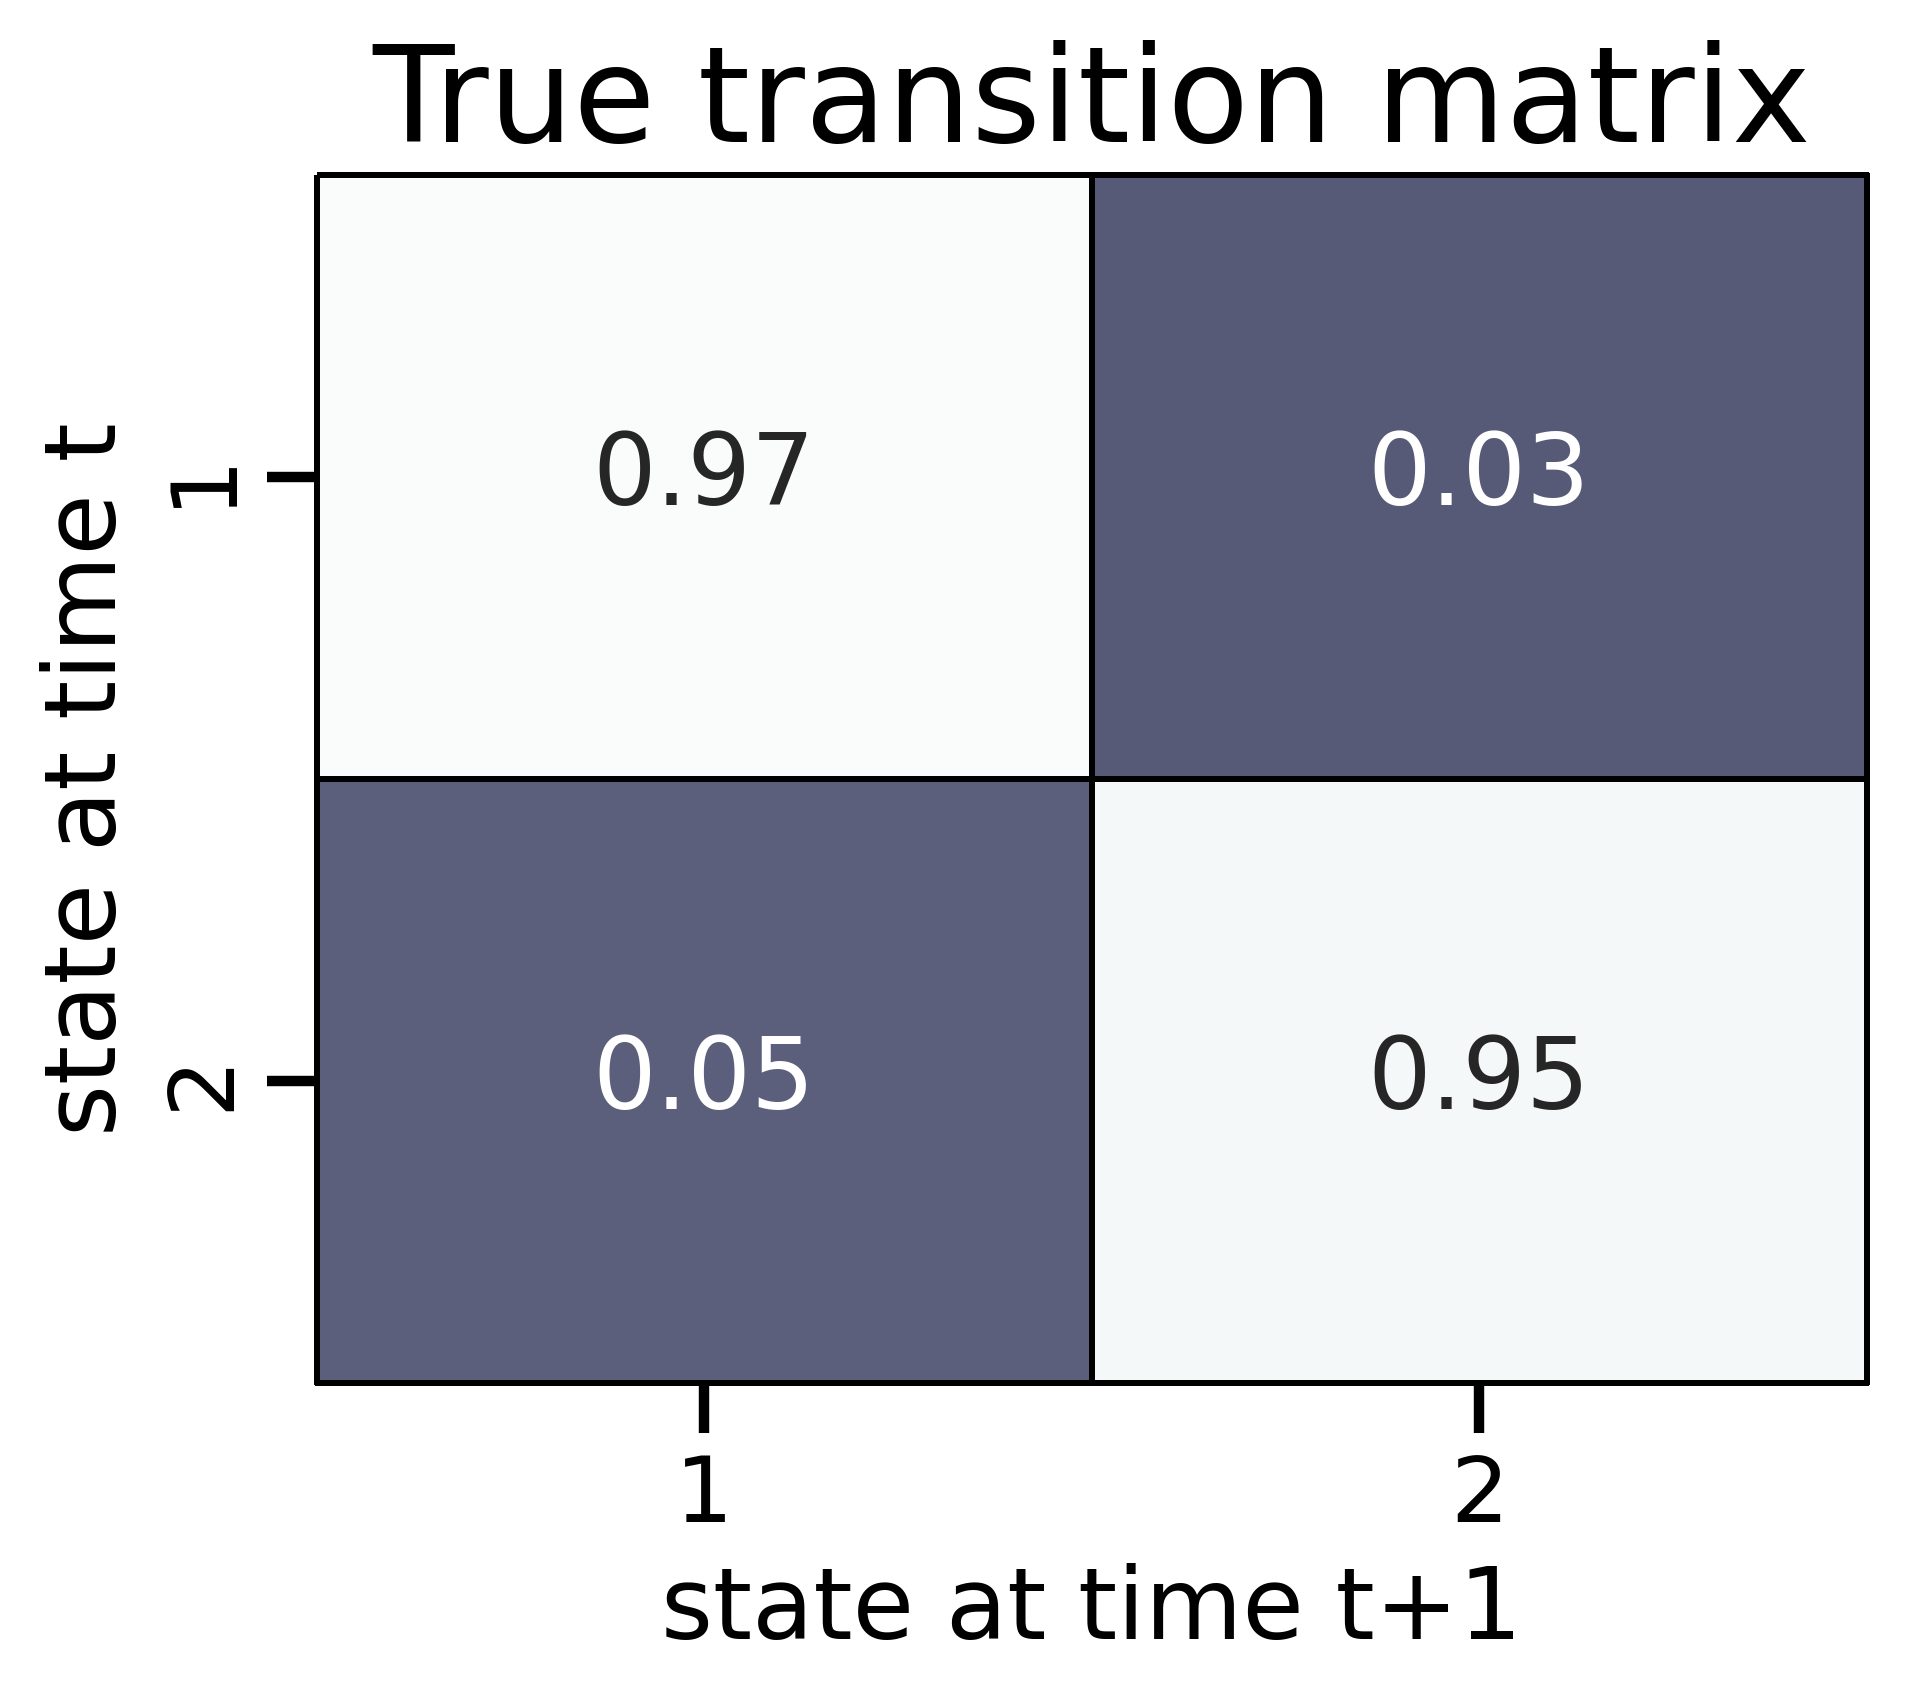

In [8]:
# True Constant Transition Matrix
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95

plot_transition_matrix(trueP, title='True transition matrix')
plt.title('True transition matrix', size=24)
plt.savefig(f'../figures_M1/TrueP_2-state.png', bbox_inches='tight', dpi=400)

In [9]:
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
# x, y, _ = dGLM_HMM.simulate_data(trueW, trueP, truepi, sessInd, save=True, title=f'/N={N}_{K}_state_constant-drift_')
x = np.load(f'../data_M1/N={N}_{K}_state_constant-drift_x.npy')
y = np.load(f'../data_M1/N={N}_{K}_state_constant-drift_y.npy')

In [10]:
# Fitting using cross-validation

# splitFolds = 5
# presentTrain, presentTest = split_data(N, sessInd, folds=5, blocks=10, random_state=1)

# sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
# maxiter = 250
# fit_init_states=False

# allP = np.zeros((splitFolds, len(sigmaList), K, K))
# allpi = np.zeros((splitFolds, len(sigmaList), K))
# allW = np.zeros((splitFolds, len(sigmaList), N, K, D, C))
# # trainLl = np.zeros((splitFolds, len(sigmaList), maxiter))
# testLl = np.zeros((splitFolds, len(sigmaList)))
# testAccuracy = np.zeros((splitFolds, len(sigmaList)))

# for fold in range(0, splitFolds):
#     print("Fold ",fold)
#     # fitting 
#     allP[fold], allpi[fold], allW[fold], _, testLl[fold], testAccuracy[fold] = fit_eval_CV_multiple_sigmas(K, x, y, sessInd, presentTrain[fold], presentTest[fold], sigmaList=sigmaList, maxiter=maxiter, glmhmmW=None, glmhmmP=None, L2penaltyW=1, priorDirP=None, fit_init_states=fit_init_states)

# # saving 
# np.save(f'../data_M1/N={N}_{K}_P_CV_sigma1D_simulated_data', allP)
# np.save(f'../data_M1/N={N}_{K}_W_CV_sigma1D_simulated_data', allW)
# np.save(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data', testLl)
# np.save(f'../data_M1/N={N}_{K}_testAccuracy_CV_sigma1D_simulated_data', testAccuracy)




In [11]:
# indSigma = 9
# for fold in range(0, splitFolds):
#     sortedStateInd = get_states_order(allW[fold, indSigma], sessInd, stimCol=[1])
#     fig, axes = plt.subplots()
#     plot_transition_matrix(allP[fold, indSigma], f'recovered P for sigma={np.round(sigmaList[indSigma],2)} fold {fold}', sortedStateInd=sortedStateInd)
#     fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
#     plotting_weights(allW[fold, indSigma], sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma={np.round(sigmaList[indSigma],2)} fold {fold}', save_fig=False, sortedStateInd=sortedStateInd)

In [12]:
# Fitting models with different number of states than the true one

# splitFolds = 5
# presentTrain, presentTest = split_data(N, sessInd, folds=5, blocks=10, random_state=1)

# sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
# maxiter = 250
# fit_init_states=False

# for K in [1,3]:

#     allP = np.zeros((splitFolds, len(sigmaList), K, K))
#     allpi = np.zeros((splitFolds, len(sigmaList), K))
#     allW = np.zeros((splitFolds, len(sigmaList), N, K, D, C))
#     # trainLl = np.zeros((splitFolds, len(sigmaList), maxiter))
#     testLl = np.zeros((splitFolds, len(sigmaList)))
#     testAccuracy = np.zeros((splitFolds, len(sigmaList)))

#     for fold in range(0, splitFolds):
#         print("Fold ",fold)
#         # fitting 
#         allP[fold], allpi[fold], allW[fold], _, testLl[fold], testAccuracy[fold] = fit_eval_CV_multiple_sigmas(K, x, y, sessInd, presentTrain[fold], presentTest[fold], sigmaList=sigmaList, maxiter=maxiter, glmhmmW=None, glmhmmP=None, L2penaltyW=1, priorDirP=None, fit_init_states=fit_init_states)

#     # saving 
#     np.save(f'../data_M1/N={N}_K={K}_P_CV_sigma1D_simulated_data_2-state', allP)
#     np.save(f'../data_M1/N={N}_K={K}_W_CV_sigma1D_simulated_dat_2-statea', allW)
#     np.save(f'../data_M1/N={N}_K={K}_testLl_CV_sigma1D_simulated_data_2-state', testLl)
#     np.save(f'../data_M1/N={N}_K={K}_testAccuracy_CV_sigma1D_simulated_data_2-state', testAccuracy)

In [13]:
# loading previously fit models
splitFolds = 5
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
allP = np.load(f'../data_M1/N={N}_{K}_P_CV_sigma1D_simulated_data.npy')
allW = np.load(f'../data_M1/N={N}_{K}_W_CV_sigma1D_simulated_data.npy')
testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data.npy')
testAccuracy = np.load(f'../data_M1/N={N}_{K}_testAccuracy_CV_sigma1D_simulated_data.npy')

# indSigma = 9
# for fold in range(0, splitFolds):
#     sortedStateInd = get_states_order(allW[fold, indSigma], sessInd, stimCol=[1])
#     fig, axes = plt.subplots()
#     plot_transition_matrix(allP[fold, indSigma], f'recovered P for sigma={np.round(sigmaList[indSigma],1)} fold {fold}', sortedStateInd=sortedStateInd)
#     fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
#     plotting_weights(allW[fold, indSigma], sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for sigma={np.round(sigmaList[indSigma],2)} fold {fold}', save_fig=False, sortedStateInd=sortedStateInd)

In [14]:
# # Plotting test log likelihood for different number of trials used
# fig, axes = plt.subplots(1, figsize = (12,5), dpi=400) # for figure 2 paper
# K=2

# T = 2000
# N = 20 * T
# testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data.npy')
# plot_testLl_CV_sigma(np.mean(testLl,0), sigmaList, f'T={T}', colormap[2], axes, linestyle='-o', alpha=1)

# T = 1000
# N = 20 * T
# testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data.npy')
# plot_testLl_CV_sigma(np.mean(testLl,0), sigmaList, f'T={T}', colormap[1], axes, linestyle='-o', alpha=1)

# T = 500
# N = 20 * T
# testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data.npy')
# plot_testLl_CV_sigma(np.mean(testLl,0), sigmaList, f'T={T}', colormap[0], axes, linestyle='-o', alpha=1)

# axes.set_ylabel('test log_like (trial)')
# # axes.set_title('dGLM-HMM with constant transition matrix P')
# axes.set_xlabel('')
# axes.spines[['right', 'top']].set_visible(False)

# sigmaList3 = [sigmaList[ind] for ind in range(len(sigmaList)) if ind%3==1]
# axes.set_xticks([-2 + np.log(sigmaList[1])]+list(np.log(sigmaList3)),['GLM-HMM'] + [f'{np.round(sigma,3)}' for sigma in sigmaList3[:2]] + [f'{np.round(sigma,2)}' for sigma in sigmaList3[2:]])
# # fig.suptitle('Model performance as a function of # states and ', size=22)
# axes.set_yticks([-0.64,-0.63,-0.62])
# plt.savefig(f'../figures_M1/TestLl_vs_Sigma_T-effect.png', bbox_inches='tight', dpi=400)

# T = 1000
# N = 20 * 1000

# Supplemental Figure 1A

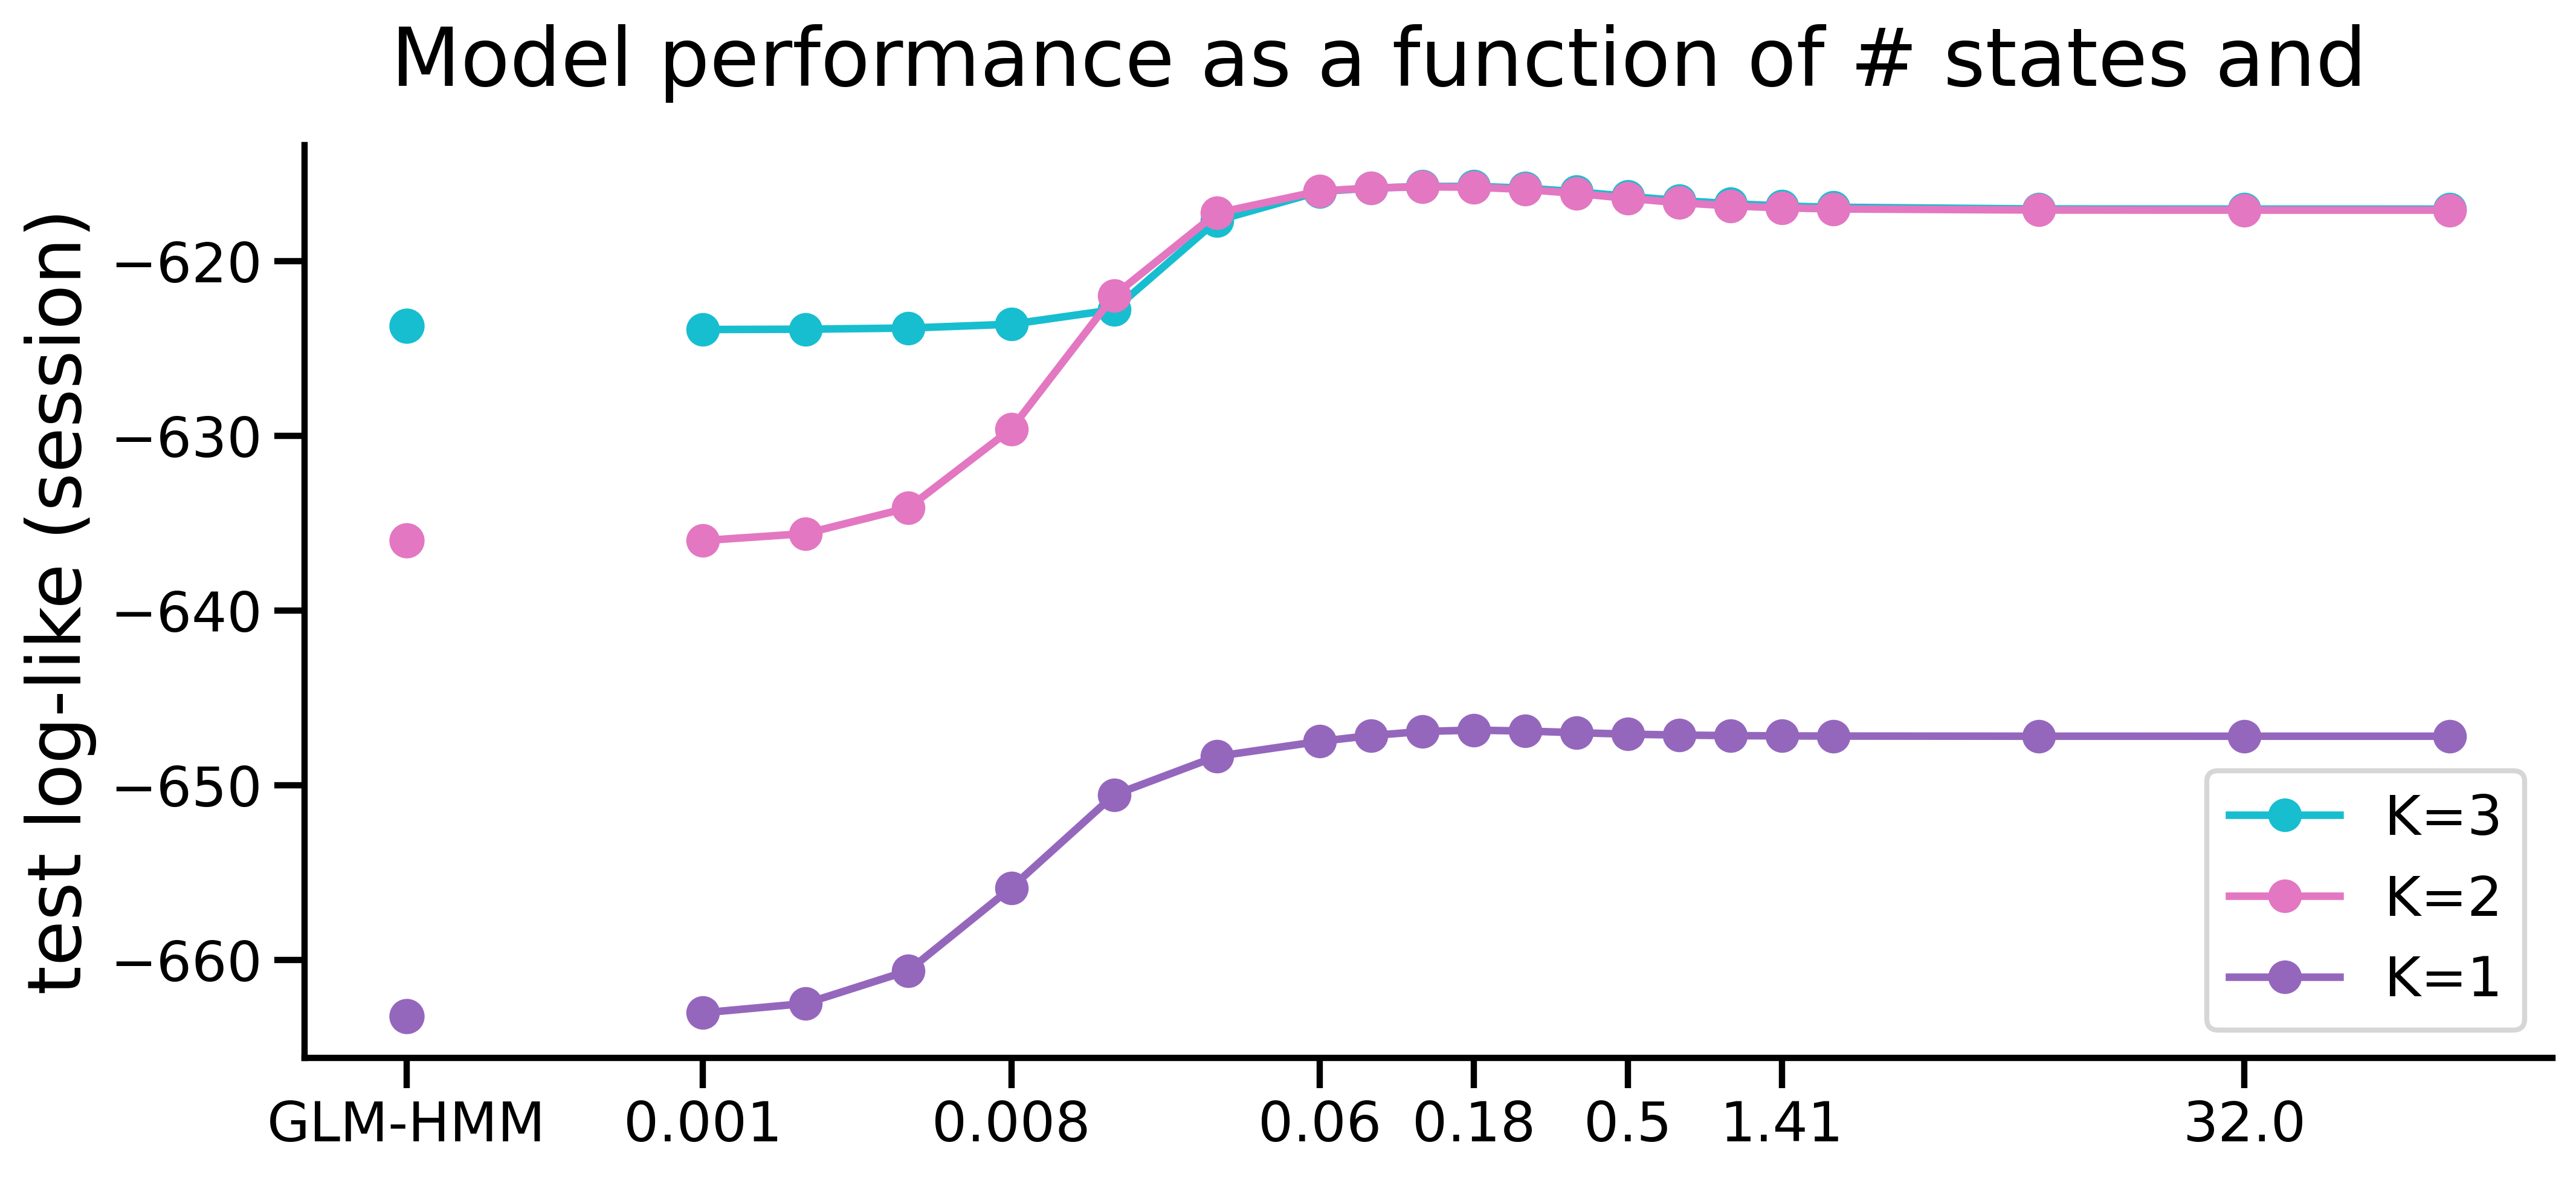

In [16]:
avg_session_length = 1000

fig, axes = plt.subplots(1, figsize = (12,5), dpi=400)
sigmaList3 = [sigmaList[ind] for ind in range(len(sigmaList)) if ind%3==1]
K = 3
testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data_2-state.npy')
plot_testLl_CV_sigma(np.mean(testLl,0) * avg_session_length, sigmaList, f'K={K}', colormap[2], axes, linestyle='-o', alpha=1)

K = 2
testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data.npy')
plot_testLl_CV_sigma(np.mean(testLl,0) * avg_session_length, sigmaList, f'K={K}', colormap[1], axes, linestyle='-o', alpha=1)

K = 1
testLl = np.load(f'../data_M1/N={N}_{K}_testLl_CV_sigma1D_simulated_data_2-state.npy')
plot_testLl_CV_sigma(np.mean(testLl,0) * avg_session_length, sigmaList, f'K={K}', colormap[0], axes, linestyle='-o', alpha=1)

axes.set_ylabel('test log-like (session)', size=22)
axes.set_xlabel('')
axes.spines[['right', 'top']].set_visible(False)
sigmaList3 = [sigmaList[ind] for ind in range(len(sigmaList)) if ind%3==1]
axes.set_xticks([-2 + np.log(sigmaList[1])]+list(np.log(sigmaList3)),['GLM-HMM'] + [f'{np.round(sigma,3)}' for sigma in sigmaList3[:2]] + [f'{np.round(sigma,2)}' for sigma in sigmaList3[2:]])
fig.suptitle('Model performance as a function of # states and ', size=24)
plt.savefig(f'../figures_M1/TestLl_vs_Sigma_K-effect.png', bbox_inches='tight', dpi=400)


# Supplemental Figure 1C

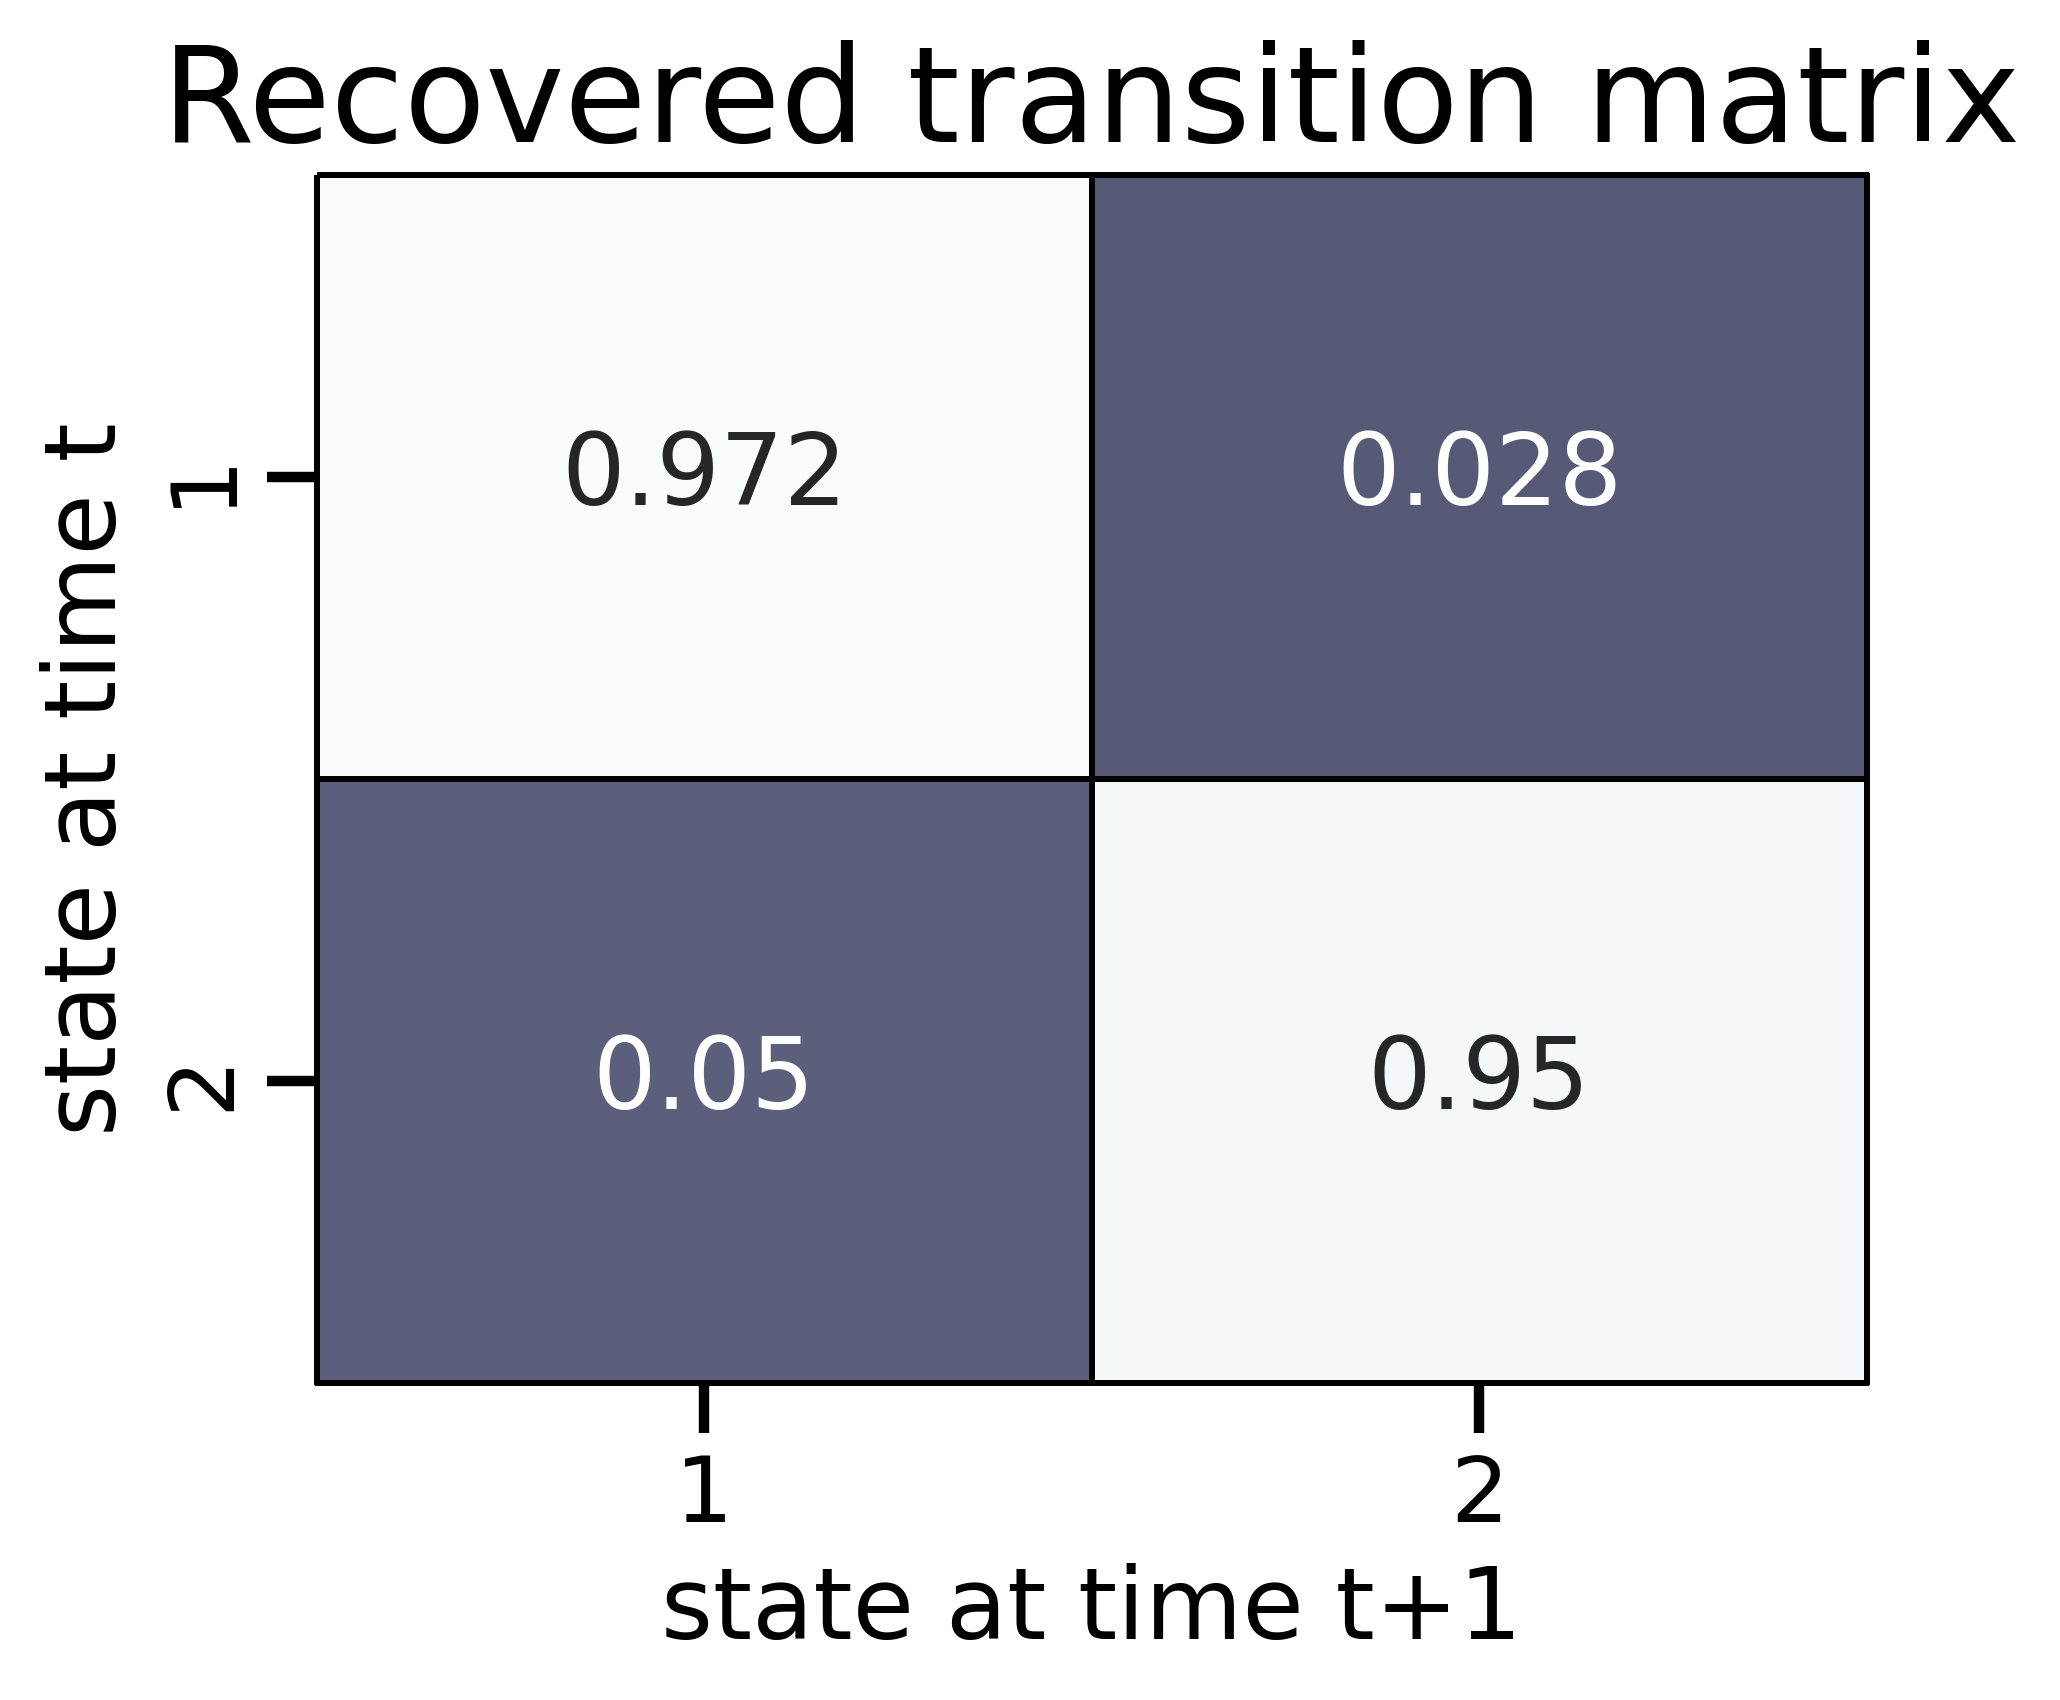

In [56]:
K = 2 
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
allP = np.load(f'../data_M1/N={N}_{K}_P_CV_sigma1D_simulated_data.npy')
allW = np.load(f'../data_M1/N={N}_{K}_W_CV_sigma1D_simulated_data.npy')
bestIndSigma = 9 # best sigma across averaged testLl of folds
bestSigma = sigmaList[bestIndSigma]
dglmhmmW = np.mean(allW, axis=0) # averaging across folds and taking best sigma
globalP = np.mean(allP, axis=0)
sortedStateInd = get_states_order(dglmhmmW[bestIndSigma], sessInd, stimCol=[1])

plot_transition_matrix(globalP[bestIndSigma], f'Recovered transition matrix', sortedStateInd=sortedStateInd)
plt.title('Recovered transition matrix', size=24)
plt.savefig(f'../figures_M1/RecoveredP_2-state_sigma=0.1.png', bbox_inches='tight', dpi=400)

# Supplemental Figure 1E

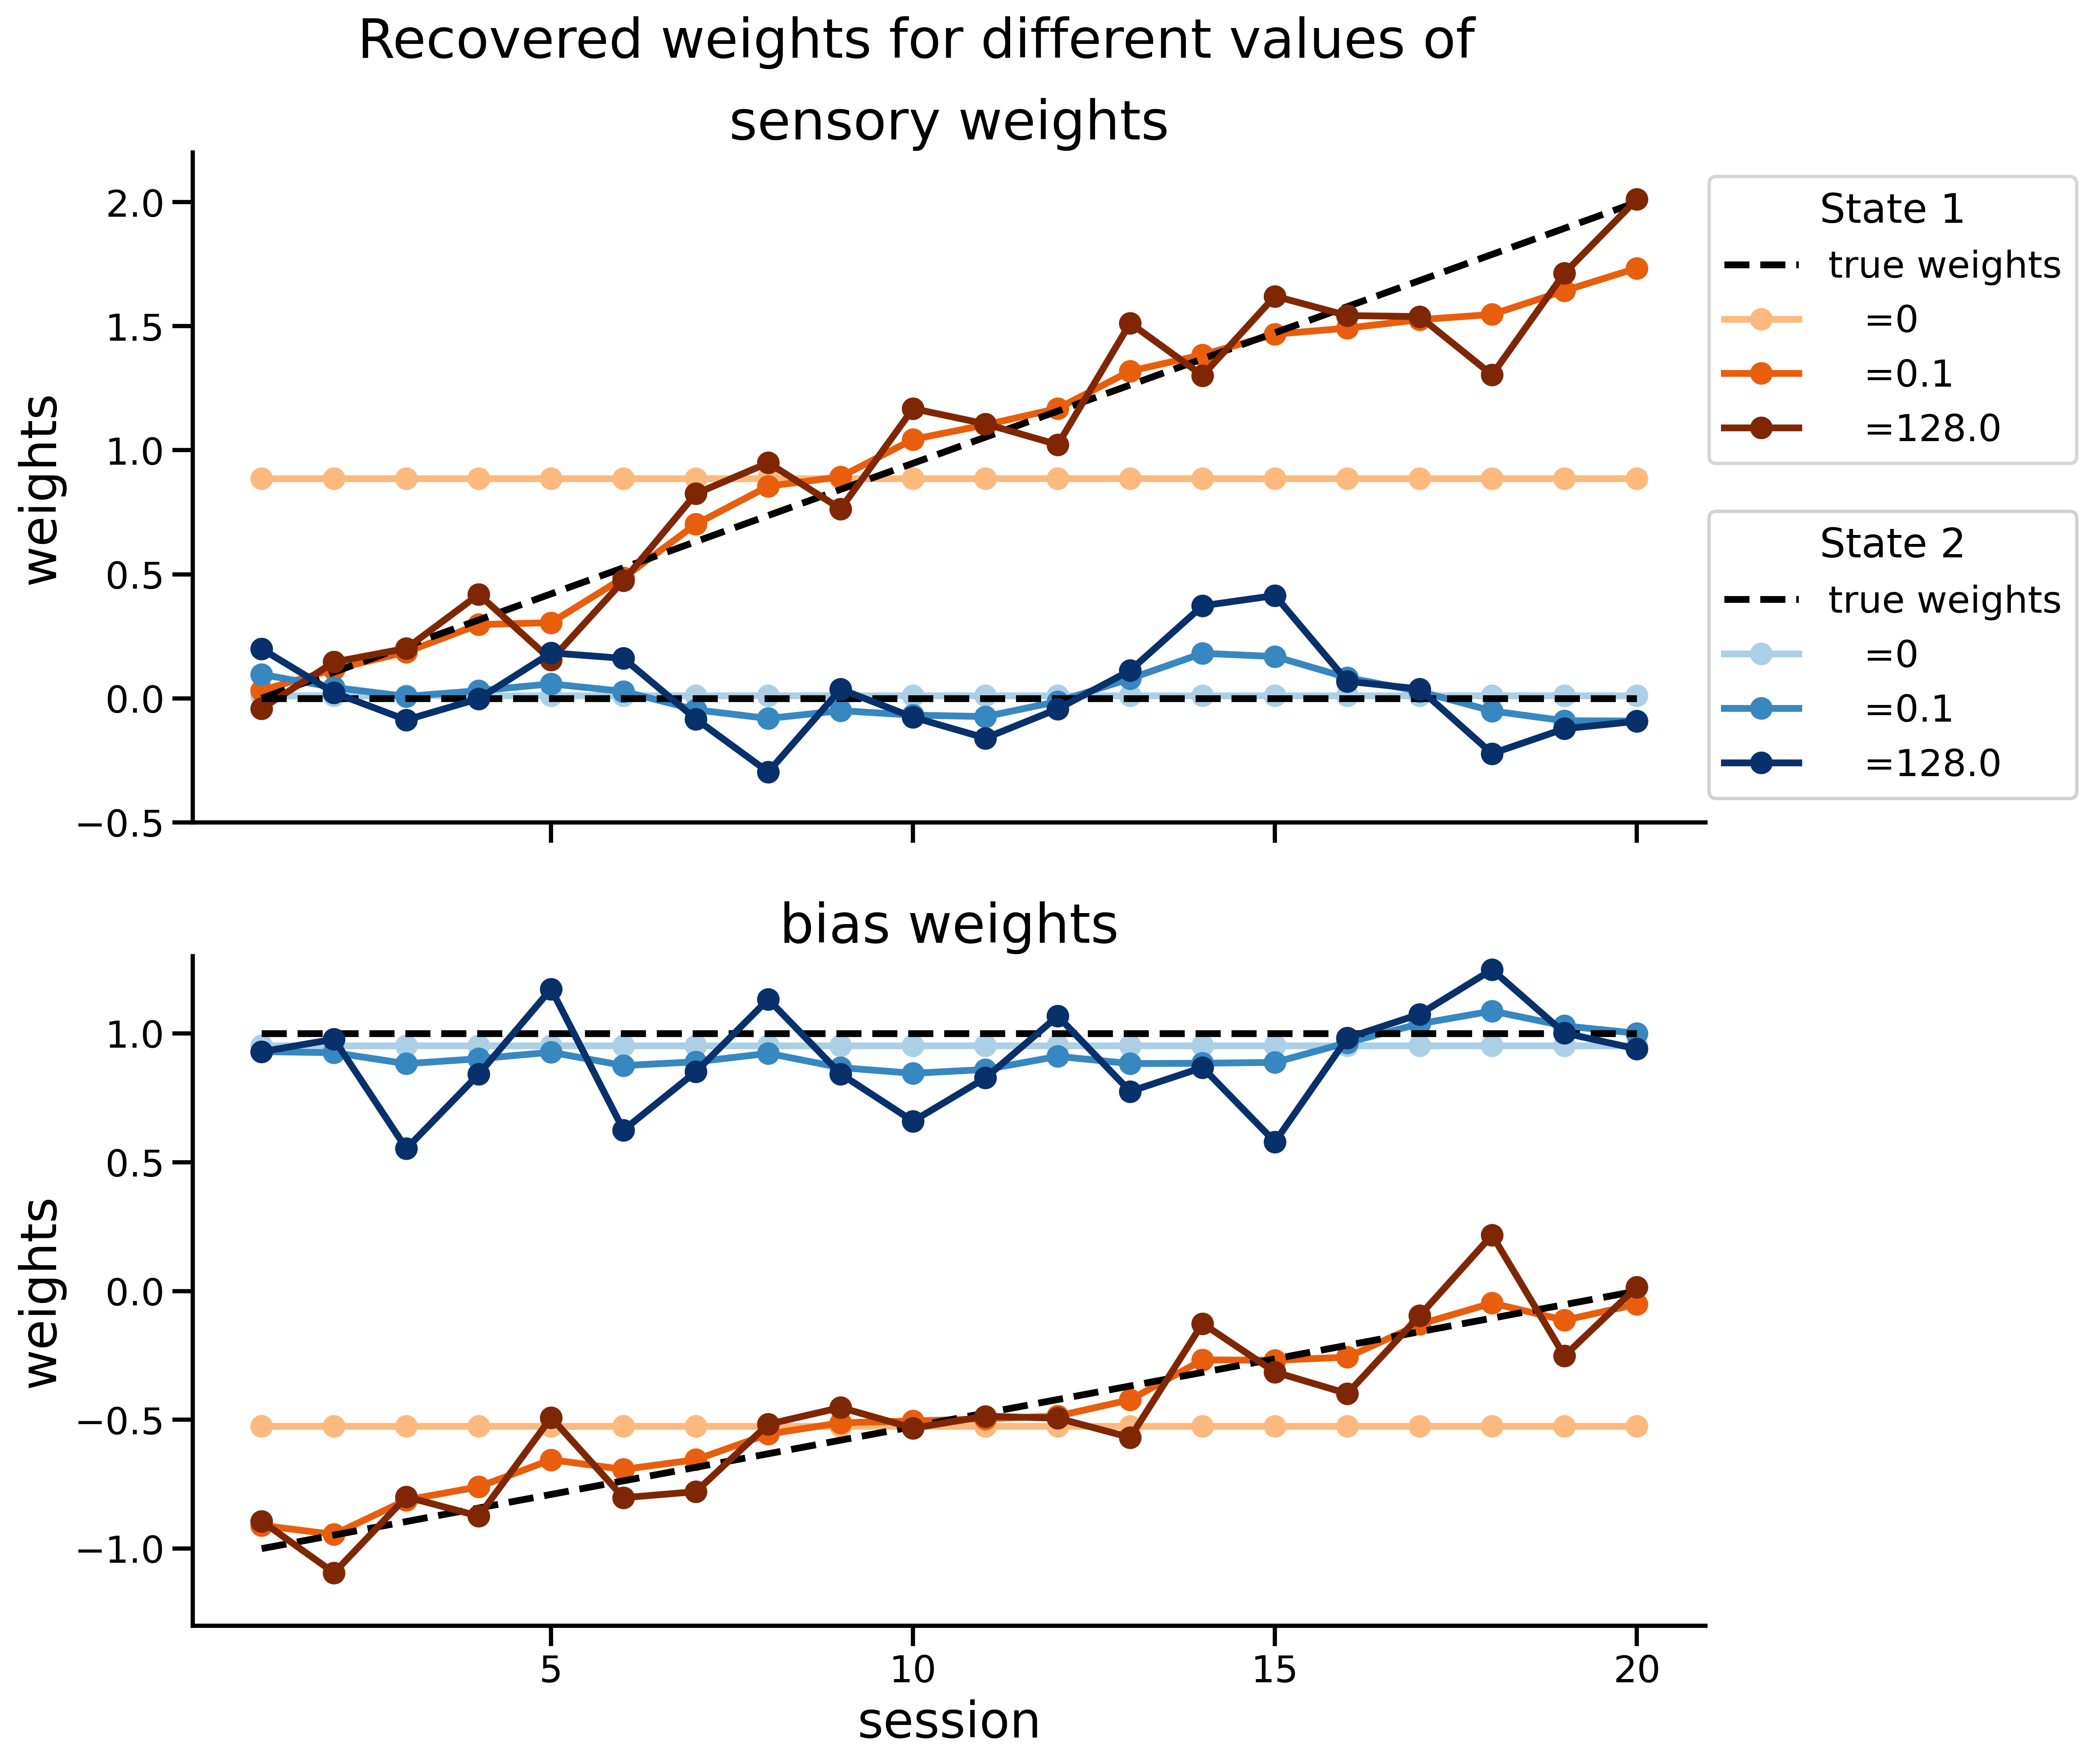

In [57]:
sns.set_context("talk")
def plotting_weight_across_sigmas(w, trueW, sessInd, sigmaList, sigmaPlotInd, axes, sortedStateInd=None, colormaps = ['Blues','Reds'], myFeatures=['bias','sensory'], bestIndSigma=9):
    ''' 
    only working for first D=2 features of w (function used for simulated data)
    '''

    if (sortedStateInd is not None):
        w = w[:,:,sortedStateInd,:,:]

    sess = len(sessInd)-1
    K = w.shape[2]
    D = 2
    for d in range(0,D):
        locs = [0.75,0.25]
        for k in range(K):
            z = 0
            axes[d].plot(range(1,sess+1),trueW[sessInd[:-1],k,1-d,1],color='black', linestyle='dashed', linewidth=3, label=f'true weights', zorder=2)
            for ind in sigmaPlotInd:
                axes[d].plot(range(1,sess+1),w[ind,sessInd[:-1],k,1-d,1],color=colormaps[k].to_rgba(z+2),linewidth=3,  marker='o',label=f'   ={np.round(sigmaList[ind],1)}', zorder=z)
                z += 1

        axes[d].set_xticks(range(1,sess+1))
        axes[d].set_title(f'{myFeatures[1-d]} weights', fontsize=24)
        axes[d].set_ylabel('weights', size=22)
        axes[D-1].set_xlabel('session', size=22)
        axes[d].set_xticks([5,10,15,20])
        if (d==1):
            axes[1-d].set_ylim([-0.5,2.2])
        else:
            axes[1-d].set_ylim([-1.3,1.3])
    lines = axes[0].get_lines()
    include = [0,1,2,3]
    legend1 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, locs[0]), title = "State 1")
    include = [4,5,6,7]
    legend2 = axes[0].legend([lines[i] for i in include],[lines[i].get_label() for i in include], loc = 'center left', bbox_to_anchor=(0.99, locs[1]), title = "State 2")
    axes[0].add_artist(legend1)
    axes[0].add_artist(legend2)
# fig, axes = plt.subplots(D, 1,figsize=(13,11), sharex=True) # for figure 2 paper
fig, axes = plt.subplots(D, 1,figsize=(12,12), sharex=True, dpi=400) # for poster
# fig.tight_layout()
plotting_weight_across_sigmas(dglmhmmW, trueW, sessInd, sigmaList, sigmaPlotInd=[0,9,20], axes=axes, sortedStateInd=sortedStateInd, colormaps = [cmapBlue,cmapRed])
# axes[0].set_title('Recovered vs true weights for different       values', fontsize=25)
sns.set_context("talk")
axes[0].spines[['right', 'top']].set_visible(False)
axes[1].spines[['right', 'top']].set_visible(False)
fig.suptitle('Recovered weights for different values of ', size=24, y=0.95)
plt.savefig(f'../figures_M1/weights_across_sigmas.png', bbox_inches='tight', dpi=400)

In [55]:
# True Global Transition Matrix
ourP = np.zeros((2,2))
ourP[0,0]=0.97
ourP[0,1]=0.03
ourP[1,0]=.05
ourP[1,1]=.95

alpha = 200 # true alpha
# trueP = np.zeros((N,K,K))
# for sess in range(0,S):
#     a = np.random.dirichlet(alpha * ourP[0])
#     b = np.random.dirichlet(alpha * ourP[1])
#     for t in range(0,T):
#         trueP[sess*T+t,0] = a
#         trueP[sess*T+t,1] = b
oldSessInd = np.arange(0,20*5000+5000,5000)
oldP = np.load(f'../data_M2/TrueP_N=40000_Dirichlet-alpha={alpha}.npy')
# print(oldP.shape)
trueP = reshapeTransitionMatrix(oldP, oldSessInd, sessInd) # change shape to match

# fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
# plotting_self_transition_probabilities(trueP, sessInd, axes, title=f'True P drawn from Dirichlet with alpha = {alpha}', linestyle='-o',colorsStates=colorsStates, save_fig=False, sortedStateInd=None)

In [32]:
# load data for model with dynamic weights and transition matrix
K = 2
dGLM_HMM1 = dglm_hmm1.dGLM_HMM1(N,K,D,C)
dGLM_HMM2 = dglm_hmm2.dGLM_HMM2(N,K,D,C)
# x, y, _ = dGLM_HMM2.simulate_data(trueW, trueP, truepi, sessInd, save=True, title=f'N={N}_{K}-state_DirP-alpha={alpha}_')
x = np.load(f'../data_M2/N={N}_{K}-state_DirP-alpha={alpha}_x.npy')
y = np.load(f'../data_M2/N={N}_{K}-state_DirP-alpha={alpha}_y.npy')

In [33]:
# splitFolds = 5
# presentTrain, presentTest = split_data(N, sessInd, folds=5, blocks=10, random_state=1)

# alphaList = [(10**x) for x in list(np.arange(-1,1,0.5,dtype=float))] + [(10**x) for x in list(np.arange(1,3,0.25,dtype=float))] + [(10**x) for x in list(np.arange(3,5.5,0.5,dtype=float))] 
# maxiter = 250
# fit_init_states=False

# allP = np.zeros((splitFolds, len(alphaList)+1, N, K, K))
# allpi = np.zeros((splitFolds, len(alphaList)+1, K))
# allW = np.zeros((splitFolds, len(alphaList)+1, N, K, D, C))
# trainLl = np.zeros((splitFolds, len(alphaList)+1, maxiter))
# testLl = np.zeros((splitFolds, len(alphaList)+1))
# testAccuracy = np.zeros((splitFolds, len(alphaList)+1))

# for fold in range(0, splitFolds):
#     print("Fold ",fold)
#     # fitting 
#     allP[fold], allpi[fold], allW[fold], trainLl[fold], testLl[fold], testAccuracy[fold] = fit_eval_CV_multiple_alphas(K, x, y, sessInd, presentTrain[fold], presentTest[fold], alphaList=alphaList, maxiter=maxiter, dglmhmmW=dglmhmmW, globalP=globalP, bestSigma=bestSigma, L2penaltyW=1, fit_init_states=fit_init_states)
   
# # saving 
# np.save(f'../data_M2/N={N}_{K}_P_CV_alphas_simulated_data', allP)
# np.save(f'../data_M2/N={N}_{K}_W_CV_alphas_simulated_data', allW)
# np.save(f'../data_M2/N={N}_{K}_testLl_CV_alphas_simulated_data', testLl)
# np.save(f'../data_M2/N={N}_{K}_testAccuracy_CV_alphas_simulated_data', testAccuracy)

In [34]:
splitFolds = 5
alphaList = [(10**x) for x in list(np.arange(-1,1,0.5,dtype=float))] + [(10**x) for x in list(np.arange(1,3,0.25,dtype=float))] + [(10**x) for x in list(np.arange(3,5.5,0.5,dtype=float))] 
allP = np.load(f'../data_M2/N={N}_{K}_P_CV_alphas_simulated_data.npy')
allW = np.load(f'../data_M2/N={N}_{K}_W_CV_alphas_simulated_data.npy')
testLl = np.load(f'../data_M2/N={N}_{K}_testLl_CV_alphas_simulated_data.npy')
testAccuracy = np.load(f'../data_M2/N={N}_{K}_testAccuracy_CV_alphas_simulated_data.npy')
sortedStateInd = get_states_order(dglmhmmW[bestIndSigma], sessInd, stimCol=[1])

# indAlpha = 6
# for fold in range(0, splitFolds):
#     fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
#     plotting_self_transition_probabilities(allP[fold, indAlpha], sessInd, axes, trueP=trueP, title=f'True P drawn from Dirichlet with alpha={np.round(alphaList[indAlpha],2)}', save_fig=False, sortedStateInd=None)
#     fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
#     plotting_weights(allW[fold, indAlpha], sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for alpha={np.round(alphaList[indAlpha],2)} fold {fold}', save_fig=False, sortedStateInd=sortedStateInd)

# Supplemental Figure 1F

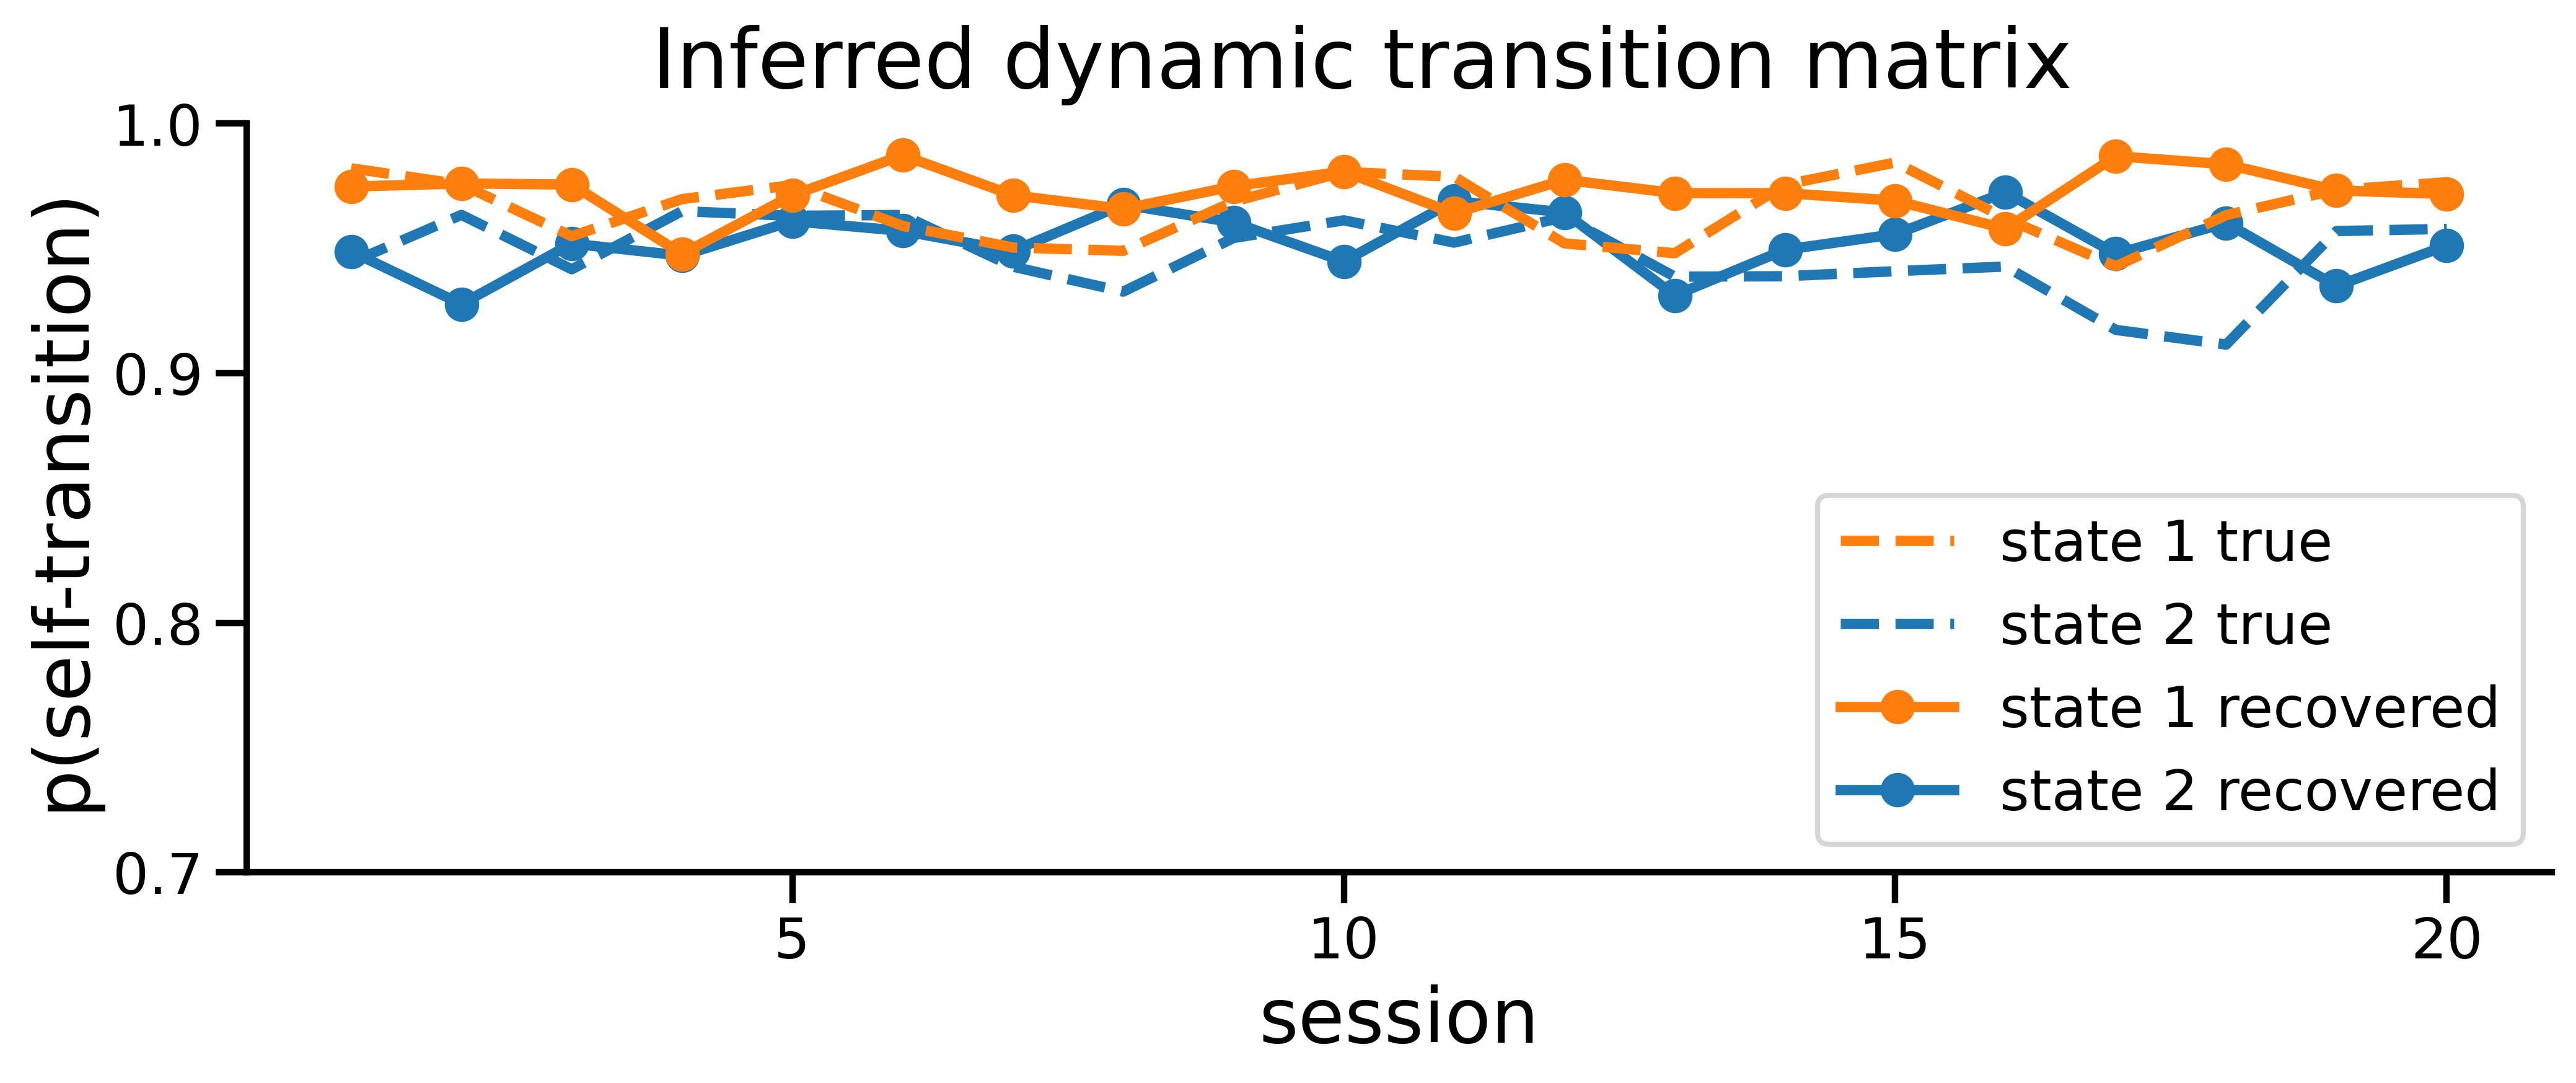

In [49]:
indAlpha = 8
# fig, axes = plt.subplots(1, figsize = (14,6), dpi=400) # for paper
fig, axes = plt.subplots(1, figsize = (12,4), dpi=400) # for poster
# plotting_self_transition_probabilities(np.mean(allP, axis=0)[-2], sessInd, axes, linewidth=3, trueP=None, title=f'', save_fig=False, sortedStateInd=None, colorsStates=colorsStates)
plotting_self_transition_probabilities(trueP, sessInd, axes, linewidth=3, title=f'', sortedStateInd=None, colorsStates=colorsStates, labels=[f'state {i+1} true' for i in range(0,3)],linestyle='--')
plotting_self_transition_probabilities(np.mean(allP, axis=0)[indAlpha], sessInd, axes, linewidth=3, title=f'', sortedStateInd=None, labels=[f'state {i+1} recovered' for i in range(0,3)], colorsStates=colorsStates)
axes.set_ylim([0.7,1])
axes.set_xticks([5,10,15,20])
axes.spines[['right', 'top']].set_visible(False)
# axes.set_title(f'Recovered    =100 vs true transition matrix', fontsize=25)
axes.legend(loc = 'lower right')
fig.suptitle('Inferred dynamic transition matrix', size=24)
axes.set_ylabel('p(self-transition)', size=22)
axes.set_xlabel('session', size=22)
plt.savefig(f'../figures_M1/Self-transition_probabilties-indAlpha={indAlpha}.png', bbox_inches='tight', dpi=400)
# fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
# plotting_weights(np.mean(allW, axis=0)[indAlpha], sessInd, axes=axes,  trueW=trueW, title=f'Recovered weights for alpha={np.round(alphaList[indAlpha],2)}', save_fig=False, sortedStateInd=sortedStateInd)

# Supplemental Figure 1D

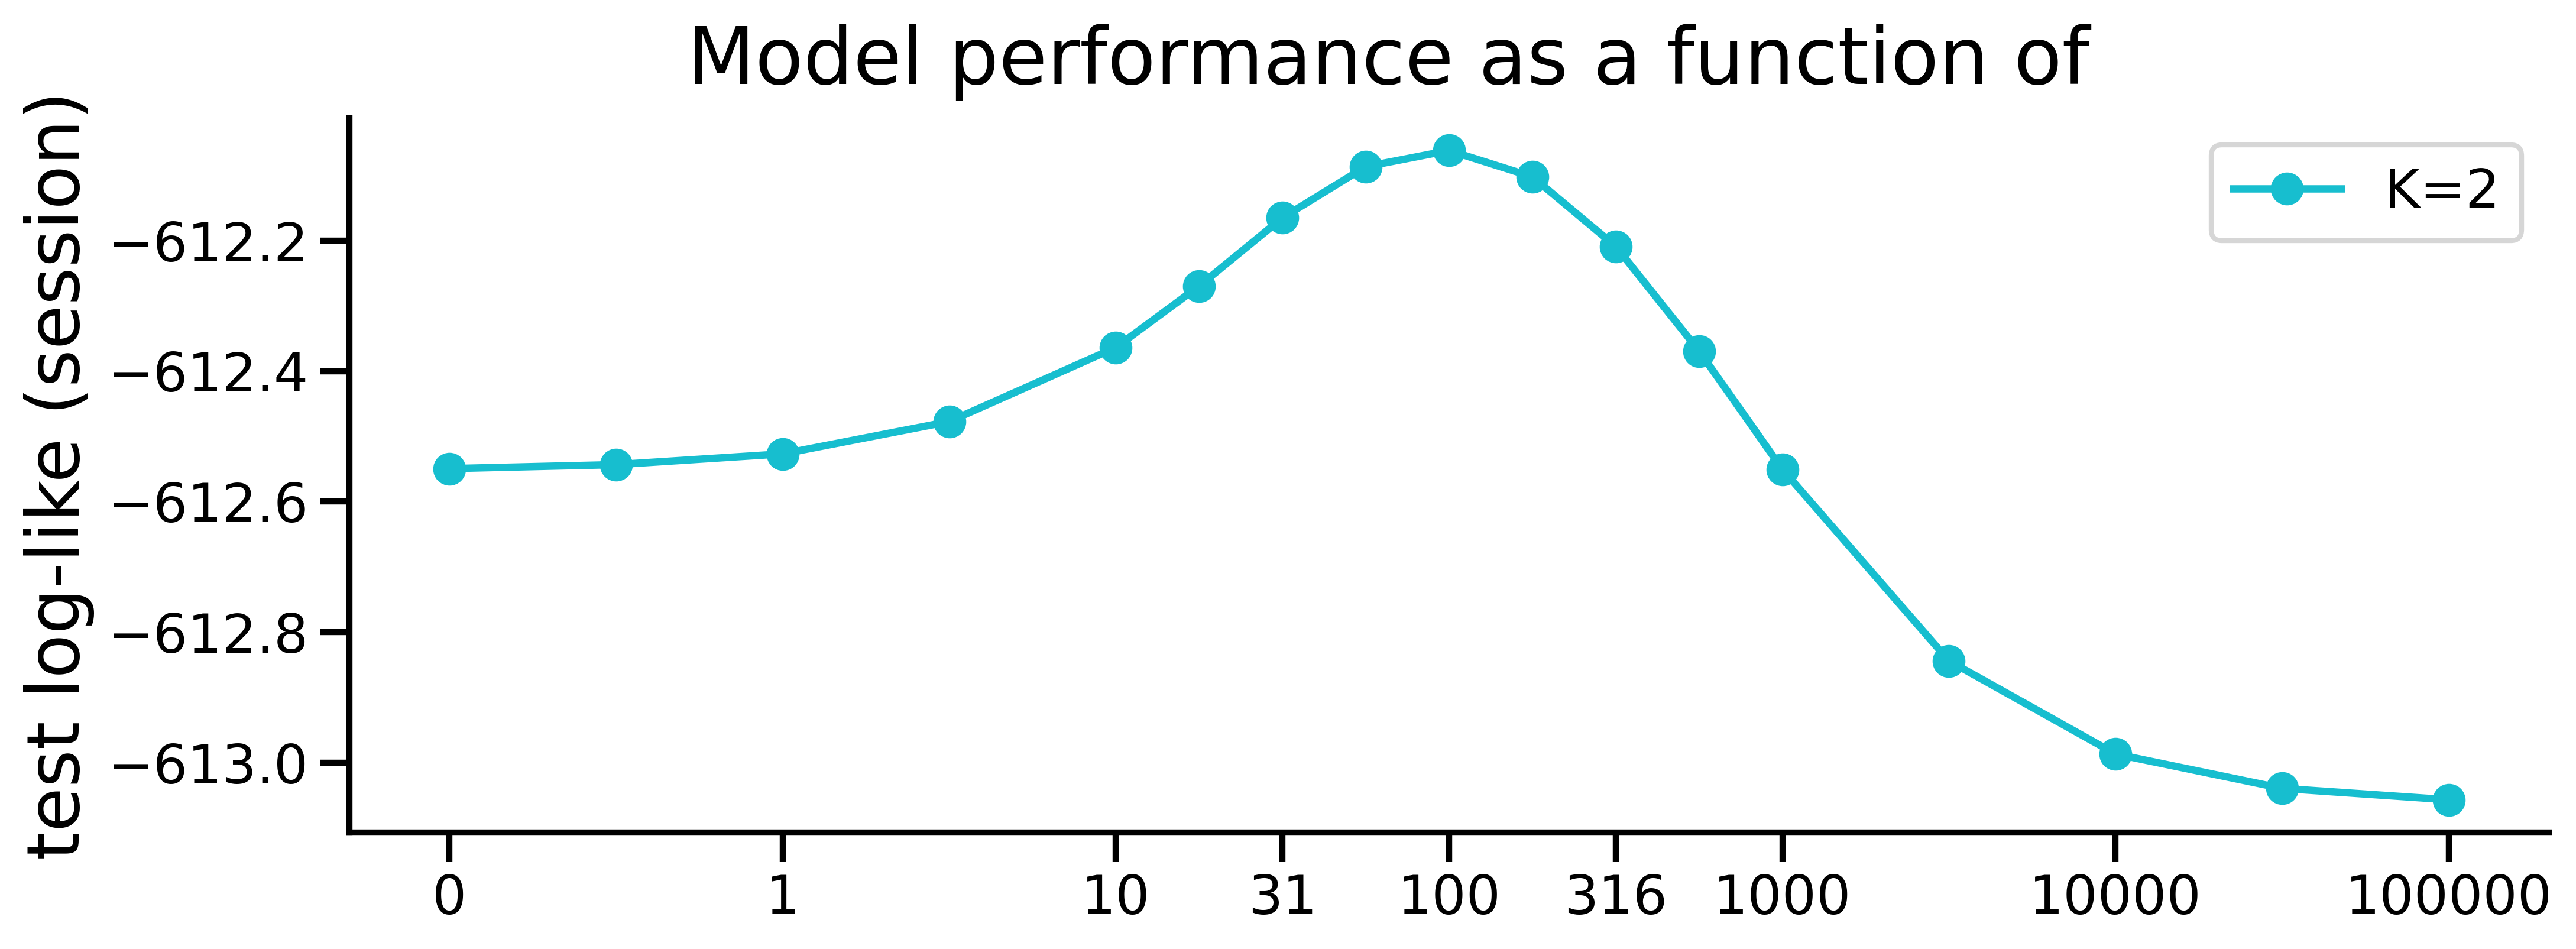

In [41]:
fig, axes = plt.subplots(1, figsize = (12,4), dpi=400) # for poster
axes.plot(np.log10(alphaList), np.mean(testLl,axis=0)[:-1] * avg_session_length, color = colormap[2], marker='o', label='K=2')
alphaListEven = [alphaList[ind] for ind in range(0,len(alphaList),2)]
axes.set_xticks(np.log10(alphaListEven),[f'{np.round(alpha,1).astype(int)}' for alpha in alphaListEven])
axes.set_ylabel('test log-like (session)', size=22)
axes.set_xlabel('')
axes.spines[['right', 'top']].set_visible(False)
fig.suptitle('Model performance as a function of  ', size=24)
axes.legend(loc='upper right')
plt.savefig(f'../figures_M1/TestLl_vs_Alpha.png', bbox_inches='tight', dpi=400)